# Seminar 3: CTC Forward-Backward and Greedy Decoder

The goal of this seminar is to implement the CTC Forward-Backward algorith for Soft-Alignment and Greedy Decoder

In [4]:
#!L
import collections
import os
import math
import numpy as np
import time

from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchaudio
from torch import optim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Tokenizer Class

In [5]:
#!L
# Class to transform text to strings of token indecies
class Tokenizer:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        _ 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_indecies(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['_']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def indecies_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('_', ' ')

In [6]:
tokenizer = Tokenizer()

## Obtain Soft-Alignment via CTC Forward-Backward Algorithm (8 points)

Use your newfound knowledge of the CTC forward-backward algorithm to obtain a soft-alignment

Remember, that the forward variable is computed as follows:

$$
  \begin{aligned}
    &\alpha_t(0) = 0, \forall t & \\
    &\alpha_1(1) = {\tt P}(z_1 = \epsilon | \mathbf{X}_{1:T}), &\\
    &\alpha_1(2) = {\tt P}(z_1 = \omega^{'}_2 | \mathbf{X}_{1:T}), &\\
    &\alpha_1(s) = 0,\ \forall s > 2 &\\
    &\alpha_t(s) = 0,\ \forall s < (2L+1) -2(T-t) -1 &  \text{top right zeros}\\
    &\alpha_t(s) = \left \{
  \begin{aligned}
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) \big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s-2}^{'} \\
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) + \alpha_{t-1}(s-2)\big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

Backward Variable is computeed like so:

$$
  \begin{aligned}
    &\beta_T(2L+1) = 1 &\\
    &\beta_T(2L) = 1 & \\
    &\beta_T(s) = 0, \forall s < 2L &\\
    &\beta_t(s) = 0,\ \forall s > 2t &\\
    &\beta_t(2L+2) = 0,\ \forall t  & \text{Bottom left zeros} \\
    &\beta_t(s) = \left \{
  \begin{aligned}
    &\big(\beta_{t+1}(s) + \beta_{t+1}(s+1) \big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s+2}^{'} \\
    &\big(\beta_{t+1}(s) +\beta_{t+1}(s+1) + \beta_{t+1}(s+2)\big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

The alignment is then given as:

$$
  \text{align}_t(s) = \frac{\alpha_t(s)\beta_t(s)}{\sum_{s}\alpha_t(s)\beta_t(s)}
$$


Doing the computation in Probability space can be numerically unstable, so you should do it in Log-Space using the
provided logsumexp operation. Remember to return to prob space at the end. You should get something like:

<img src="alignment.png">

If you convert the alignment to log-space it will look like:

<img src="alignment_log.png">

In [234]:
#!L
from matplotlib.colors import LogNorm
# Stable log sum exp
NEG_INF = -float("inf")
def logsumexp(*args):
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max)
                       for a in args))
    return a_max + lsp


def forward_algorithm(sequence, matrix, blank=28):
    # Matrix is has shape [K, T]

    # Turn probs into log-probs
    # matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    # Initialze
    alphas = np.full([len(mod_sequence), matrix.shape[1]], 0.0)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            #First Step
            if t == 0 and (0 <= s <= 1):
                alphas[s, t] = matrix[mod_sequence[s], t]
            else:
                # Need to do this stabily
                a_t_1_s = alphas[s, t - 1] if 0 < t else 0.0
                a_t_1_s_1 = alphas[s - 1, t - 1] if 0 < t and 0 < s else 0.0
                a_t_1_s_2 = alphas[s - 2, t - 1] if 0 < t and 1 < s else 0.0
                if mod_sequence[s] == blank or (1 < s and mod_sequence[s] == mod_sequence[s - 2]):
                    alphas[s, t] = (a_t_1_s + a_t_1_s_1) * matrix[mod_sequence[s], t]
                else:
                    alphas[s, t] = (a_t_1_s + a_t_1_s_1 + a_t_1_s_2) * matrix[mod_sequence[s], t]
        c_t = np.sum(alphas[:, t])
        alphas[:, t] = alphas[:, t] / c_t
    return alphas

def backward_algorithm(sequence, matrix, blank=28):
    # Matrix has shape [K, T] where K - 29 

    # Turn probs into log-probs
    # matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    betas = np.full([len(mod_sequence), matrix.shape[1]], 0.0)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            #First Step
            if t == matrix.shape[1]-1:
                if s == len(mod_sequence) - 1:
                    betas[s, t] = matrix[blank, -1]
                elif s == len(mod_sequence) - 2:
                    betas[s, t] = matrix[mod_sequence[-2], -1]

            else:
                b_t_1_s = betas[s, t + 1] if t < matrix.shape[1] - 1 else 0.0
                b_t_1_s_1 = betas[s + 1, t + 1] if t < matrix.shape[1] - 1 and s < len(mod_sequence) - 1 else 0.0
                b_t_1_s_2 = betas[s + 2, t + 1] if t < matrix.shape[1] - 1 and s < len(mod_sequence) - 2 else 0.0

                if mod_sequence[s] == blank or (s < len(mod_sequence) - 2 and mod_sequence[s] == mod_sequence[s + 2]):
                    betas[s, t] = (b_t_1_s + b_t_1_s_1) * matrix[mod_sequence[s], t]
                else:
                    betas[s, t] = (b_t_1_s + b_t_1_s_1 + b_t_1_s_2) * matrix[mod_sequence[s], t]
        d_t = np.sum(betas[:, t])
        betas[:, t] = betas[:, t] / d_t
    return betas

def soft_alignment(labels_indecies, matrix):
    alphas = forward_algorithm(labels_indecies, matrix)
    betas = backward_algorithm(labels_indecies, matrix)

    # Move from log space back to prob space
    align = alphas * betas

    # Normalize Alignment
    col_sums = [np.sum(align[:, j]) for j in range(align.shape[1])]
    for i in range(align.shape[0]):
        for j in range(align.shape[1]):
            align[i, j] /= col_sums[j]

    return align

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


AssertionError: 

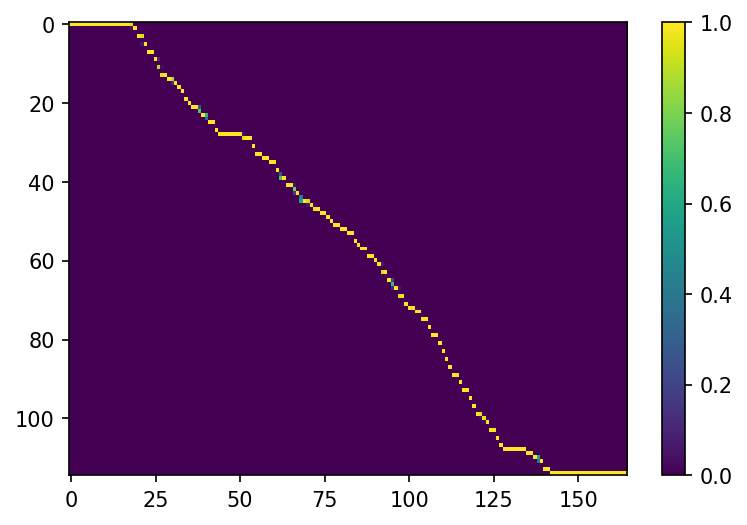

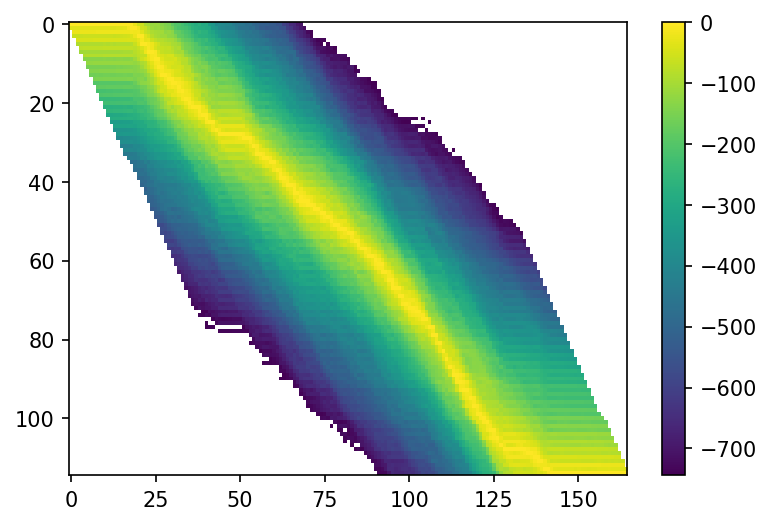

In [235]:
#!L
# Test your implementation

#Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt('test_matrix.txt')
# Create label_sequence
labels_indecies = tokenizer.text_to_indecies('there se ms no good reason for believing that twillc ange')

align = soft_alignment(labels_indecies, matrix)

plt.figure(dpi=150)
plt.imshow(align, aspect='auto', interpolation='nearest')
plt.colorbar()

plt.figure(dpi=150)
plt.imshow(np.log(align), aspect='auto', interpolation='nearest')
plt.colorbar()

ref_align = np.loadtxt('soft_alignment.txt')

assert np.allclose(ref_align, align)

## Implement a Greedy Best-Path Decoder! (2 points)

Your goal is to implement a Greedy Best-Path decoder. Remember than in CTC the joint distribution over states factors out into a product of marginals:

$${\tt P}(\mathbf{z}_{1:T}|\mathbf{X}_{1:T},\mathbf{\theta}) = \prod_{1:T}^T{\tt P}(z_t|\mathbf{X}_{1:T},\mathbf{\theta})$$

Mostly likely state sequence is:

$$\mathbf{\pi}^*_{1:T} = \arg \max_{\mathbf{pi}_{1:T} } \prod_{t=1}^T {\tt P}(z_t = \pi_t|\mathbf{X}_{1:T})$$

Then merge repeats and remove blanks.

In [239]:
#!L
def GreedyDecoder(output: torch.Tensor, labels: list, label_lengths: list, blank_label=28, collapse_repeated=True):
    """ist
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: Listof torch.Tensor of label indecies
    :param label_lengths:  int of label lengths
    :param blank_label:
    :param collapse_repeated:
    :return: 
    """

    # Get max class
    arg_maxes = torch.argmax(output, axis=-1)

    decodes = []
    targets = []

    #For targets and decodes remove r
    for i, args in enumerate(arg_maxes):
        decode = []

        targets.append(tokenizer.indecies_to_text(labels[i][:label_lengths[i]].tolist()))

        # Remove repeeats, then remove blanks

        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j - 1]:
                    continue
                decode.append(index.item())
        decodes.append(tokenizer.indecies_to_text(decode))
    return decodes, targets

In [240]:
#!L
# TESTING THE GREEDY DECODER

#Load numpy matrix, add axis [batch,classes,time]
matrix = np.loadtxt('test_matrix.txt')[np.newaxis,:,:]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1,2)

# Create list of torch tensor
labels_indecies = [torch.Tensor(tokenizer.text_to_indecies('there seems no good reason for believing that it will change'))]

# Run the Decoder
decodes, targets = GreedyDecoder(matrix, labels_indecies, [len(labels_indecies[0])])

assert decodes[0] == 'there se ms no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

## Seminar Ends and Homework Begins here

In [ ]:
#!L
